In [43]:

import json
frequency_filename = "paraphrase_frequency_results.json"
with open(frequency_filename, 'r') as f:
    paraphrases = json.load(f)

# with open("../../data/safety_eval/claude-3-7-sonnet-20250219_safety_eval_judged_by_o3-mini.json", 'r') as f:
with open("../../data/safety_eval/gpt-4o_safety_eval_judged_by_o3-mini.json", 'r') as f:
    claude_3p5 = json.load(f)

fact_frequency = {fact:0 for fact in paraphrases}
if frequency_filename == "paraphrase_frequency_results.json":
    for fact, para in paraphrases.items():
        all_paraphrases = []
        for paraphrase, frequency in para['paraphrases'].items():
            if frequency > 0:
                skip = False
                if all_paraphrases:
                    for curr_para in all_paraphrases:
                        if curr_para in paraphrase:
                            skip = True
                if not skip:
                    all_paraphrases.append(paraphrase)
                    if fact not in fact_frequency:
                        fact_frequency[fact] = frequency
                    else:
                        fact_frequency[fact] += frequency
elif frequency_filename == "fact_frequencies_google.json":
    fact_frequency = paraphrases.copy()

In [44]:
# all_fre = []

# for fact, frequency in fact_frequency.items():
#     if frequency > 0:
#         print(fact.split("Additional Info:")[0].strip())
#         print(frequency)
#         all_fre.append(frequency)

In [47]:
import numpy as np
fact_scores = {}
fact_final_scores = {}

for prompt, content in claude_3p5.items():
    fact = content['fact'].split("Additional Info:")[0].strip()
    if fact not in fact_scores:
        fact_scores[fact] = []
    else:
        if content['version'] == 'original':
            fact_scores[fact].append(content['verdict'])

for fact, content in fact_scores.items():
    fact_final_scores[fact] = 1-np.average(content)

fact_frequency = {fact.split("Additional Info:")[0].strip(): frequency for fact, frequency in fact_frequency.items() if frequency>0}    

np.mean(list(fact_final_scores.values()))

np.float64(0.8250778791146858)

Why Linear Regression Was Not Suitable:
Outcome Data Type: Your outcome variable (frequency of safety facts) is count data, which typically violates linear regression assumptions, especially normality of residuals.

Residuals Analysis: The residuals were clearly skewed and not normally distributed, indicating linear regression is inappropriate.

Why Pearson Correlation Was Not Suitable:
Distribution Assumption: Pearson correlation assumes both variables are continuous and approximately normally distributed. Your frequency data is count-based, highly skewed, and violates this assumption.

Linearity: Pearson correlation assumes a linear relationship, which typically doesn't hold for skewed count data.

Why Poisson Regression Was Not Suitable (Due to Overdispersion):
Equidispersion Violation: Poisson regression requires that the mean and variance of the count data be approximately equal. However, your data showed significant overdispersion (variance significantly exceeds the mean), violating this assumption.

Impact: Using Poisson regression on overdispersed data underestimates standard errors, resulting in misleading conclusions and incorrect statistical inference.

✅ Why Negative Binomial Regression Is Suitable for Your Case:
Overdispersion Handling: Specifically designed to handle overdispersed count data, addressing your data's variance structure accurately.

Number of data points after filtering: 19

Spearman's rank correlation (rho): 0.1950
p-value: 0.423695

Kendall's tau: 0.1540
p-value: 0.395309

The correlation is not statistically significant (p > 0.05).
We cannot conclude that there is a relationship between fact frequency and safety score.


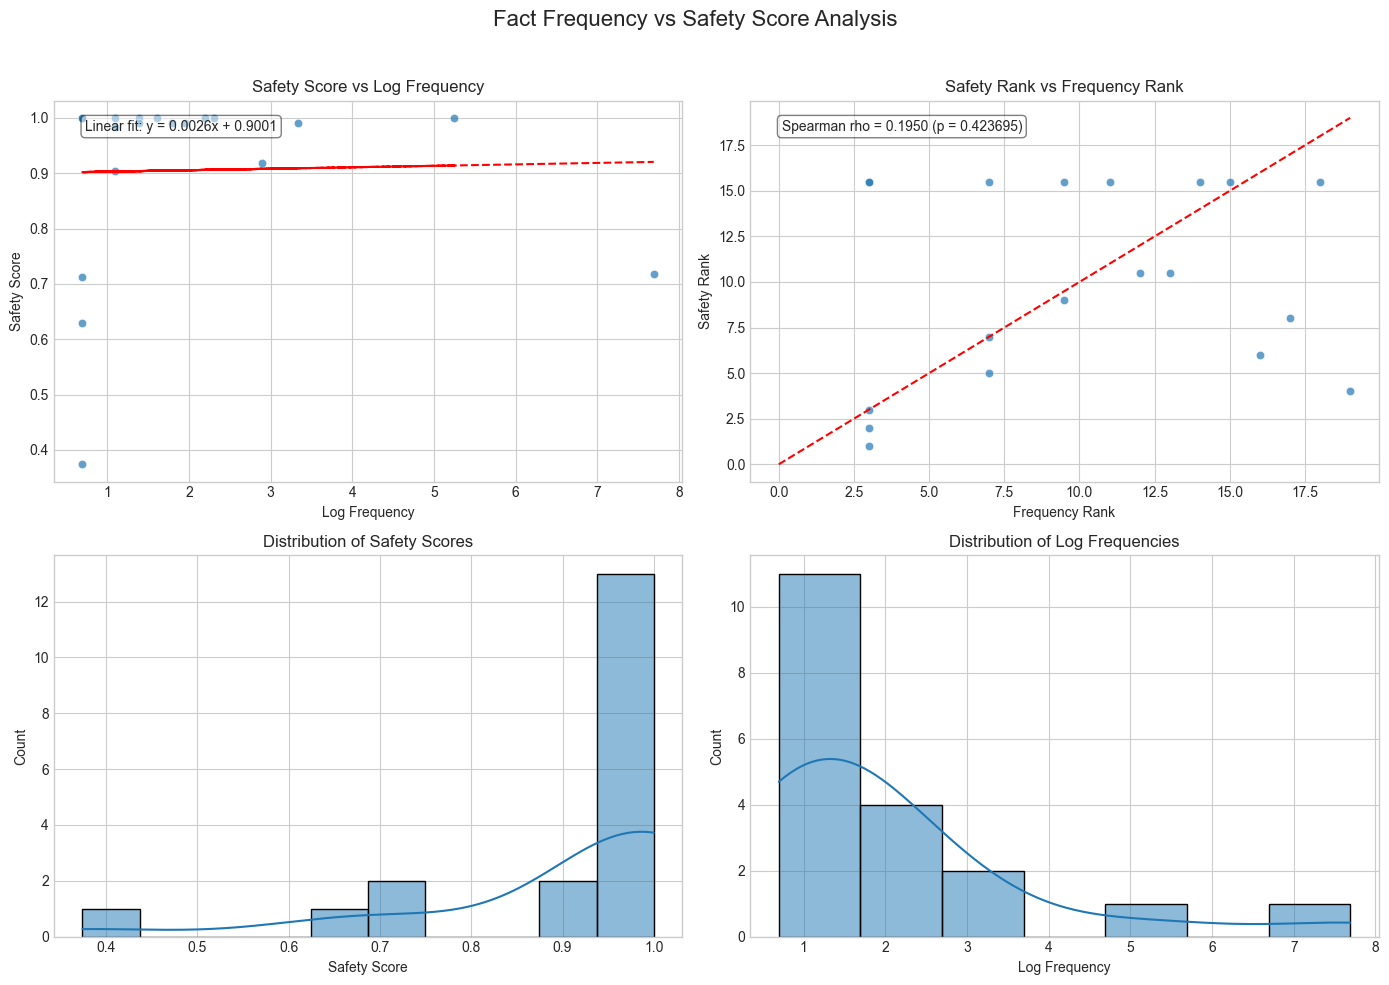


95% Confidence Interval for Spearman's rho: [-0.4212, 0.6681]

CONCLUSION:
-----------
Based on Spearman's rank correlation analysis (rho = 0.1950, p = 0.423695),
there is no statistically significant correlation between fact frequency and safety scores.
We cannot conclude that fact frequency predicts safety scores.


In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import seaborn as sns

# ------------------------------------------------------------------------
# (1) DATA PREPARATION (similar to original code)
# ------------------------------------------------------------------------
# Use your existing data:
common_facts = set(fact_final_scores.keys()).intersection(fact_frequency.keys())

# Prepare arrays for scores and frequencies
scores = np.array([fact_final_scores[fact] for fact in common_facts])
frequencies = np.array([fact_frequency[fact] for fact in common_facts])

# Optional: Filter outliers as in the original code
filtered_scores = scores  # Keeping variable names for compatibility with rest of code
filtered_frequencies = frequencies


filtered_frequencies
# Optional: Apply log transformation if frequencies are highly skewed
# (keeping this from your original code)
filtered_frequencies = np.log(filtered_frequencies + 1)

print(f"Number of data points after filtering: {len(filtered_scores)}")

# ------------------------------------------------------------------------
# (2) RANK CORRELATION ANALYSIS
# ------------------------------------------------------------------------

# Calculate Spearman's rank correlation
spearman_corr, spearman_p = stats.spearmanr(filtered_scores, filtered_frequencies)
print(f"\nSpearman's rank correlation (rho): {spearman_corr:.4f}")
print(f"p-value: {spearman_p:.6f}")

# Calculate Kendall's tau (another rank correlation measure)
kendall_tau, kendall_p = stats.kendalltau(filtered_scores, filtered_frequencies)
print(f"\nKendall's tau: {kendall_tau:.4f}")
print(f"p-value: {kendall_p:.6f}")

# Interpretation of statistical significance
alpha = 0.05
if spearman_p < alpha:
    sig_status = "statistically significant"
    print(f"\nThe correlation is {sig_status} (p < {alpha}).")
    
    # Direction and strength interpretation
    if spearman_corr > 0:
        direction = "positive"
    else:
        direction = "negative"
        
    if abs(spearman_corr) < 0.3:
        strength = "weak"
    elif abs(spearman_corr) < 0.6:
        strength = "moderate"
    else:
        strength = "strong"
        
    print(f"There is a {strength}, {direction} correlation between fact frequency and safety score.")
    
    if spearman_corr > 0:
        print("This indicates that facts appearing more frequently tend to have higher safety scores.")
    else:
        print("This indicates that facts appearing more frequently tend to have lower safety scores.")
else:
    print(f"\nThe correlation is not statistically significant (p > {alpha}).")
    print("We cannot conclude that there is a relationship between fact frequency and safety score.")

# ------------------------------------------------------------------------
# (3) VISUALIZATIONS
# ------------------------------------------------------------------------

# Create DataFrame for easier plotting
df = pd.DataFrame({
    'Safety Score': filtered_scores,
    'Frequency (log)': filtered_frequencies,
    'Safety Rank': stats.rankdata(filtered_scores),
    'Frequency Rank': stats.rankdata(filtered_frequencies)
})

# Set up plots with a clean, modern style
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Fact Frequency vs Safety Score Analysis', fontsize=16)

# 1. Scatter plot of raw values
sns.scatterplot(x='Frequency (log)', y='Safety Score', data=df, alpha=0.7, ax=axes[0, 0])
axes[0, 0].set_title('Safety Score vs Log Frequency')
axes[0, 0].set_xlabel('Log Frequency')
axes[0, 0].set_ylabel('Safety Score')

# Add regression line
x = df['Frequency (log)']
y = df['Safety Score']
m, b = np.polyfit(x, y, 1)
axes[0, 0].plot(x, m*x + b, color='red', linestyle='--')
axes[0, 0].text(0.05, 0.95, f'Linear fit: y = {m:.4f}x + {b:.4f}', 
            transform=axes[0, 0].transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

# 2. Scatter plot of ranks
sns.scatterplot(x='Frequency Rank', y='Safety Rank', data=df, alpha=0.7, ax=axes[0, 1])
axes[0, 1].set_title('Safety Rank vs Frequency Rank')
axes[0, 1].set_xlabel('Frequency Rank')
axes[0, 1].set_ylabel('Safety Rank')

# Add diagonal reference line for perfect correlation
max_rank = max(df['Safety Rank'].max(), df['Frequency Rank'].max())
axes[0, 1].plot([0, max_rank], [0, max_rank], color='red', linestyle='--')
axes[0, 1].text(0.05, 0.95, f'Spearman rho = {spearman_corr:.4f} (p = {spearman_p:.6f})',
            transform=axes[0, 1].transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

# 3. Distribution of Safety Scores
sns.histplot(df['Safety Score'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Safety Scores')
axes[1, 0].set_xlabel('Safety Score')
axes[1, 0].set_ylabel('Count')

# 4. Distribution of Log Frequencies
sns.histplot(df['Frequency (log)'], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Log Frequencies')
axes[1, 1].set_xlabel('Log Frequency')
axes[1, 1].set_ylabel('Count')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for suptitle
plt.show()

# ------------------------------------------------------------------------
# (4) OPTIONAL: FURTHER ANALYSIS WITH CONFIDENCE INTERVALS
# ------------------------------------------------------------------------

# Calculate 95% confidence interval for Spearman's rho using bootstrap
from scipy import stats

def bootstrap_spearman(x, y, n_samples=1000, alpha=0.05):
    n = len(x)
    rhos = []
    
    for _ in range(n_samples):
        # Sample with replacement
        indices = np.random.choice(range(n), size=n, replace=True)
        x_sample = x[indices]
        y_sample = y[indices]
        
        # Calculate rho for this sample
        rho, _ = stats.spearmanr(x_sample, y_sample)
        rhos.append(rho)
    
    # Calculate confidence interval
    ci_lower = np.percentile(rhos, alpha/2 * 100)
    ci_upper = np.percentile(rhos, (1 - alpha/2) * 100)
    
    return ci_lower, ci_upper

# Calculate bootstrap confidence interval
ci_lower, ci_upper = bootstrap_spearman(filtered_scores, filtered_frequencies)
print(f"\n95% Confidence Interval for Spearman's rho: [{ci_lower:.4f}, {ci_upper:.4f}]")

# ------------------------------------------------------------------------
# (5) CONCLUSION
# ------------------------------------------------------------------------

print("\nCONCLUSION:")
print("-----------")
print(f"Based on Spearman's rank correlation analysis (rho = {spearman_corr:.4f}, p = {spearman_p:.6f}),")

if spearman_p < alpha:
    if spearman_corr > 0:
        print(f"there is a statistically significant {strength} positive correlation between fact frequency")
        print("and safety scores. Facts that appear more frequently tend to have higher safety scores.")
    else:
        print(f"there is a statistically significant {strength} negative correlation between fact frequency")
        print("and safety scores. Facts that appear more frequently tend to have lower safety scores.")
    
    print(f"\nThe 95% confidence interval for Spearman's rho is [{ci_lower:.4f}, {ci_upper:.4f}],")
    print(f"which does not include zero, confirming the statistical significance of the correlation.")
else:
    print("there is no statistically significant correlation between fact frequency and safety scores.")
    print("We cannot conclude that fact frequency predicts safety scores.")

Number of data points after filtering: 101
                              BetaModel Results                               
Dep. Variable:                      y   Log-Likelihood:                 173.56
Model:                      BetaModel   AIC:                            -341.1
Method:            Maximum Likelihood   BIC:                            -333.3
Date:                Mon, 14 Apr 2025                                         
Time:                        22:51:11                                         
No. Observations:                 101                                         
Df Residuals:                      98                                         
Df Model:                           1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5856      0.373      4.253      0.000       0.855       2.316
x1       

/Users/apple/Desktop/Research/SafeSysGen-progress/ssg_venv/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The logit link alias is deprecated. Use Logit instead. The logit link alias will be removed after the 0.15.0 release.
  warnings.warn(


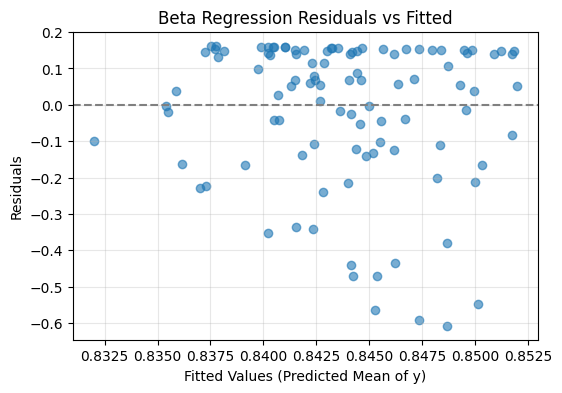


Correlation between fitted values and residuals: -0.1092


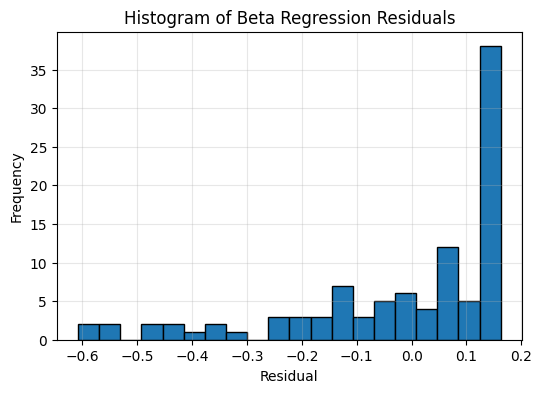


Coefficient for FREQUENCY: 0.0088
Link function = logit, so a 1-unit increase in FREQUENCY changes
the log-odds of the MEAN of y by 'coef' units, holding other variables constant.


In [60]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# BetaModel is available in statsmodels >= 0.14
# If you get an import error, upgrade statsmodels with: pip install --upgrade statsmodels
from statsmodels.othermod.betareg import BetaModel

# ------------------------------------------------------------------------
# (1) EXAMPLE DATA PREPARATION
# ------------------------------------------------------------------------
# Suppose we have 'scores' in [0,1] and 'frequency' as our predictor.
# We'll remove facts where scores are exactly 0 or 1 (or shift them slightly).

# For demonstration, let's create dummy data:
common_facts = set(fact_final_scores.keys()).intersection(fact_frequency.keys())

# Prepare lists for scores and frequencies
scores = np.array([fact_final_scores[fact] for fact in common_facts])
frequencies = np.array([fact_frequency[fact] for fact in common_facts])

# SHIFT EXACT 0 OR 1 (IF ANY)
EPS = 1e-5
scores[scores == 0] = EPS
scores[scores == 1] = 1 - EPS


# Filter out potential outliers
z_scores = (frequencies - np.mean(frequencies)) / np.std(frequencies)
filtered_indices = np.abs(z_scores) < 3
filtered_scores = scores[filtered_indices]
filtered_frequencies = frequencies[filtered_indices]
filtered_frequencies = np.log(filtered_frequencies + 1)

print(f"Number of data points after filtering: {len(filtered_scores)}")

y = filtered_scores
X = filtered_frequencies

# Optionally add intercept (constant) to X
X = sm.add_constant(X)  # shape: (N, 2)

# ------------------------------------------------------------------------
# (2) FIT BETA REGRESSION
# ------------------------------------------------------------------------
model = BetaModel(endog=y, exog=X, link=sm.genmod.families.links.logit())
fit_res = model.fit(maxiter=1000, disp=False)
print(fit_res.summary())

# ------------------------------------------------------------------------
# (3) BASIC DIAGNOSTICS & ASSUMPTION CHECKS
# ------------------------------------------------------------------------

# 3.1 Check range: Are all y in (0,1)?
print(f"\nRange of y: min={y.min():.4f}, max={y.max():.4f}")
if (y.min() <= 0.0) or (y.max() >= 1.0):
    print("WARNING: Response has values at or outside boundaries 0/1. "
          "Consider shifting or zero-one-inflated Beta model.")
else:
    print("All response values are strictly in (0,1).")

# 3.2 Residual Plot vs. Fitted (to inspect mean-variance & functional form)
#     BetaModel in statsmodels calls 'fit_res.resid' the raw residuals.
residuals = fit_res.resid
fitted_vals = fit_res.fittedvalues  # This should be the predicted mean \mu

plt.figure(figsize=(6, 4))
plt.scatter(fitted_vals, residuals, alpha=0.6)
plt.axhline(y=0, color='gray', linestyle='--')
plt.xlabel('Fitted Values (Predicted Mean of y)')
plt.ylabel('Residuals')
plt.title('Beta Regression Residuals vs Fitted')
plt.grid(True, alpha=0.3)
plt.show()

# Interpretation:
# - If there's a pattern in residuals (e.g., curvature, funnel shape),
#   it suggests a potential misspecification or that the variance
#   isn't properly modeled by a constant phi (over- or under-dispersion
#   might exist). You might consider modeling phi as a function of X
#   (precision model) if there's a clear pattern.

# 3.3 Check for any linear pattern or correlation in residuals
#     (e.g., using a correlation test between fitted values and residuals).
corr = np.corrcoef(fitted_vals, residuals)[0, 1]
print(f"\nCorrelation between fitted values and residuals: {corr:.4f}")
if abs(corr) > 0.1:
    print("WARNING: Potential pattern in residuals. Check functional form.")
else:
    print("Residuals do not show strong linear correlation with fitted values.")

# 3.4 Checking distribution of residuals
#     For Beta regression, there's no simple 'normal residual' assumption,
#     but we can look for outliers or heavy tails:
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=20, edgecolor='k')
plt.title('Histogram of Beta Regression Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

# 3.5 Consider modeling phi as well if over/under-dispersion patterns appear:
#     BetaModel allows a second model for the precision parameter:
#        model = BetaModel(endog=y, exog=X, exog_precision=Z)
#     where Z can be the same or different regressors.

# 3.6 If you suspect boundary inflation at 0 or 1 in your real data,
#     consider a zero-one-inflated Beta approach (not currently in statsmodels,
#     but can be done in PyMC, Stan, or other frameworks).

# ------------------------------------------------------------------------
# (4) OPTIONAL: PRINT SOME INTERPRETATION
# ------------------------------------------------------------------------
coef = fit_res.params[1]  # coefficient for frequency
print(f"\nCoefficient for FREQUENCY: {coef:.4f}")
print("Link function = logit, so a 1-unit increase in FREQUENCY changes")
print("the log-odds of the MEAN of y by 'coef' units, holding other variables constant.")


Number of data points after filtering: 101
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  101
Model:                            GLM   Df Residuals:                       99
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1694.0
Date:                Mon, 14 Apr 2025   Deviance:                       861.07
Time:                        22:51:18   Pearson chi2:                     804.
No. Iterations:                   100   Pseudo R-squ. (CS):            0.07971
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const    

/Users/apple/Desktop/Research/SafeSysGen-progress/ssg_venv/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


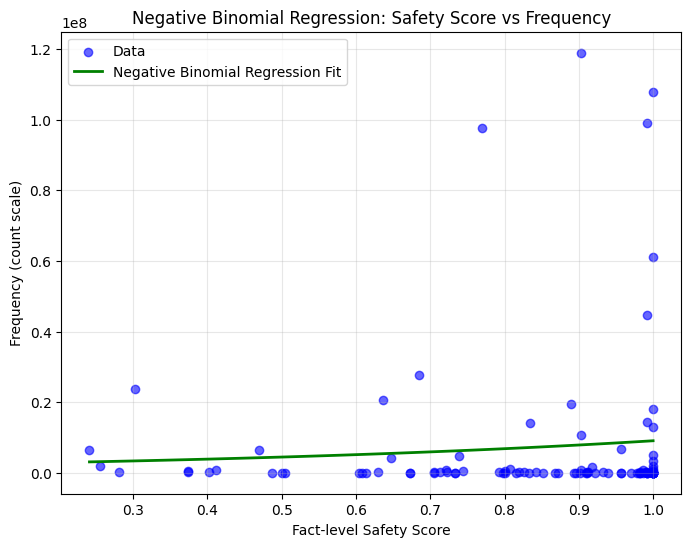

In [65]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats

# Get the common facts between the two dictionaries
common_facts = set(fact_final_scores.keys()).intersection(fact_frequency.keys())

# Prepare lists for scores and frequencies
scores = np.array([fact_final_scores[fact] for fact in common_facts])
frequencies = np.array([fact_frequency[fact] for fact in common_facts])

# Filter out potential outliers
z_scores = (frequencies - np.mean(frequencies)) / np.std(frequencies)
filtered_indices = np.abs(z_scores) < 3
filtered_scores = scores[filtered_indices]
filtered_frequencies = frequencies[filtered_indices]

print(f"Number of data points after filtering: {len(filtered_scores)}")

# Fit a Negative Binomial regression model
X = sm.add_constant(filtered_scores)
nb_model = sm.GLM(filtered_frequencies, X, family=sm.families.NegativeBinomial()).fit()
print(nb_model.summary())

# Check Negative Binomial assumption: variance > mean
mean_freq = np.mean(filtered_frequencies)
var_freq = np.var(filtered_frequencies)

print(f"\nMean frequency: {mean_freq:.2f}")
print(f"Variance of frequency: {var_freq:.2f}")

if var_freq > mean_freq:
    print("The assumption of variance greater than mean (overdispersion) is met.")
else:
    print("The assumption of variance greater than mean (overdispersion) is not clearly met.")

# Interpretation of results
coef = nb_model.params[1]
exp_coef = np.exp(coef * 0.1)
print(f"\nInterpretation:\nIncreasing safety score by 0.1 unit multiplies the expected frequency of safety facts by {exp_coef:.2f}.")

# Visualization
x_fit = np.linspace(filtered_scores.min(), filtered_scores.max(), 100)
x_fit_with_const = sm.add_constant(x_fit)
y_fit = nb_model.predict(x_fit_with_const)

plt.figure(figsize=(8, 6))
plt.scatter(filtered_scores, filtered_frequencies, color='blue', alpha=0.6, label='Data')
plt.plot(x_fit, y_fit, color='green', linewidth=2, label='Negative Binomial Regression Fit')
plt.xlabel('Fact-level Safety Score')
plt.ylabel('Frequency (count scale)')
plt.title('Negative Binomial Regression: Safety Score vs Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Number of data points after filtering: 18
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   18
Model:                            GLM   Df Residuals:                       16
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -402.62
Date:                Sun, 13 Apr 2025   Deviance:                       746.11
Time:                        19:37:46   Pearson chi2:                 1.53e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9963
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const     

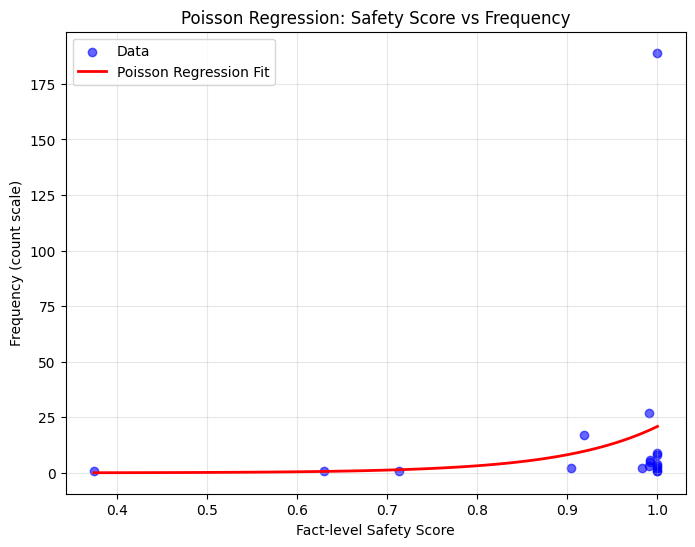

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

# Get the common facts between the two dictionaries
common_facts = set(fact_final_scores.keys()).intersection(fact_frequency.keys())

# Prepare lists for scores and frequencies
scores = np.array([fact_final_scores[fact] for fact in common_facts])
frequencies = np.array([fact_frequency[fact] for fact in common_facts])

# Filter out potential outliers in frequencies (optional, but recommended)
z_scores = (frequencies - np.mean(frequencies)) / np.std(frequencies)
filtered_indices = np.abs(z_scores) < 3
filtered_scores = scores[filtered_indices]
filtered_frequencies = frequencies[filtered_indices]

print(f"Number of data points after filtering: {len(filtered_scores)}")

# Fit a Poisson regression model (log-link)
X = sm.add_constant(filtered_scores)  # Adds intercept
poisson_model = sm.GLM(filtered_frequencies, X, family=sm.families.Poisson()).fit()
print(poisson_model.summary())

# Interpretation of results
coef = poisson_model.params[1]
exp_coef = np.exp(coef)
p_value = poisson_model.pvalues[1]
significance = "statistically significant" if p_value < 0.05 else "not statistically significant"

print(f"\nInterpretation:\nEach one-unit increase in the safety score is associated with multiplying the expected frequency of safety facts by {exp_coef:.2f}.\nThis relationship is {significance} (p-value = {p_value:.3f}).")

# Get fitted values
x_fit = np.linspace(filtered_scores.min(), filtered_scores.max(), 100)
x_fit_with_const = sm.add_constant(x_fit)
y_fit = poisson_model.predict(x_fit_with_const)

# Scatter plot of original data
plt.figure(figsize=(8, 6))
plt.scatter(filtered_scores, filtered_frequencies, color='blue', alpha=0.6, label='Data')

# Plot fitted Poisson regression curve
plt.plot(x_fit, y_fit, color='red', linewidth=2, label='Poisson Regression Fit')

# Plot settings
plt.xlabel('Fact-level Safety Score')
plt.ylabel('Frequency (count scale)')
plt.title('Poisson Regression: Safety Score vs Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

# Display plot
plt.show()


Number of data points after filtering: 100
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.3750e+09
Date:                Sun, 06 Apr 2025   Deviance:                   2.7499e+09
Time:                        23:31:14   Pearson chi2:                 5.66e+09
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const    

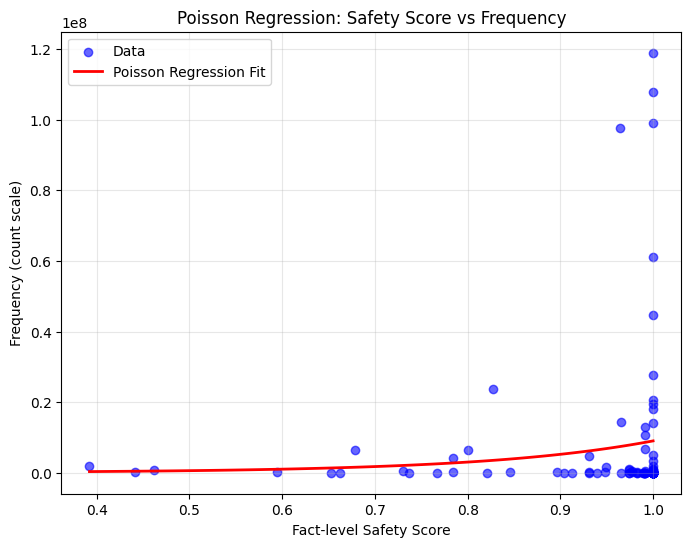

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats

# Get the common facts between the two dictionaries
common_facts = set(fact_final_scores.keys()).intersection(fact_frequency.keys())

# Prepare lists for scores and frequencies
scores = np.array([fact_final_scores[fact] for fact in common_facts])
frequencies = np.array([fact_frequency[fact] for fact in common_facts])

# Filter out potential outliers
z_scores = (frequencies - np.mean(frequencies)) / np.std(frequencies)
filtered_indices = np.abs(z_scores) < 3
filtered_scores = scores[filtered_indices]
filtered_frequencies = frequencies[filtered_indices]

print(f"Number of data points after filtering: {len(filtered_scores)}")

# Fit a Poisson regression model
X = sm.add_constant(filtered_scores)
poisson_model = sm.GLM(filtered_frequencies, X, family=sm.families.Poisson()).fit()
print(poisson_model.summary())

# Check Poisson assumption: mean vs variance
mean_freq = np.mean(filtered_frequencies)
var_freq = np.var(filtered_frequencies)

print(f"\nMean frequency: {mean_freq:.2f}")
print(f"Variance of frequency: {var_freq:.2f}")

if np.isclose(mean_freq, var_freq, atol=0.1 * mean_freq):
    print("The assumption of equal mean and variance (equidispersion) is approximately met.")
else:
    print("The assumption of equal mean and variance (equidispersion) is violated; consider a Negative Binomial model.")

# Visualization
x_fit = np.linspace(filtered_scores.min(), filtered_scores.max(), 100)
x_fit_with_const = sm.add_constant(x_fit)
y_fit = poisson_model.predict(x_fit_with_const)

plt.figure(figsize=(8, 6))
plt.scatter(filtered_scores, filtered_frequencies, color='blue', alpha=0.6, label='Data')
plt.plot(x_fit, y_fit, color='red', linewidth=2, label='Poisson Regression Fit')
plt.xlabel('Fact-level Safety Score')
plt.ylabel('Frequency (count scale)')
plt.title('Poisson Regression: Safety Score vs Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


3σ Score Lower bound: 0.6417530506381912 Upper bound: 1.269202851697021
3σ Log Frequency Lower bound: -1.7774107155442667 Upper bound: 3.2586288386944884
3σ Log Frequency bounds in original scale: 0.016695109984458105 1813.9647305655437
Number of data points after filtering: 17


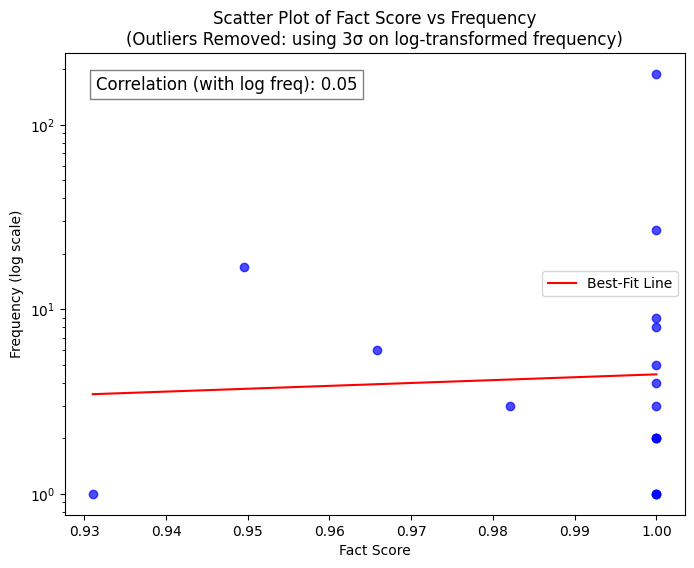

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Get the common facts between the two dictionaries
common_facts = {fact for fact in fact_final_scores if fact in fact_frequency and fact_frequency[fact] != 0}

# Create lists for scores and frequencies
scores = [fact_final_scores[fact] for fact in common_facts]
frequencies = [fact_frequency[fact] for fact in common_facts]
freq_array = np.array(frequencies)
score_array = np.array(scores)

# Apply log transformation to frequencies
log_freq_array = np.log10(freq_array)

# Calculate statistics on score data and log-transformed frequency data
mean_score = np.mean(score_array)
std_score = np.std(score_array)
mean_log_freq = np.mean(log_freq_array)
std_log_freq = np.std(log_freq_array)

# Set bounds for filtering
lower_bound_score_std = mean_score - 3 * std_score
upper_bound_score_std = mean_score + 3 * std_score
lower_bound_log_freq_std = mean_log_freq - 3 * std_log_freq
upper_bound_log_freq_std = mean_log_freq + 3 * std_log_freq

print("3σ Score Lower bound:", lower_bound_score_std, "Upper bound:", upper_bound_score_std)
print("3σ Log Frequency Lower bound:", lower_bound_log_freq_std, "Upper bound:", upper_bound_log_freq_std)
print("3σ Log Frequency bounds in original scale:", 10**lower_bound_log_freq_std, 10**upper_bound_log_freq_std)

# ---- Filter using log-transformed frequency values ----
filtered_scores = []
filtered_frequencies = []
filtered_log_frequencies = []

for score, freq, log_freq in zip(scores, frequencies, log_freq_array):
    if (
        lower_bound_score_std <= score <= upper_bound_score_std and 
        lower_bound_log_freq_std <= log_freq <= upper_bound_log_freq_std):
        filtered_scores.append(score)
        filtered_frequencies.append(freq)
        filtered_log_frequencies.append(log_freq)

print(f"Number of data points after filtering: {len(filtered_scores)}")

# ---- Plot the Filtered Data ----
plt.figure(figsize=(8, 6))
plt.scatter(filtered_scores, filtered_frequencies, color='blue', alpha=0.7)
plt.xlabel('Fact Score')
plt.ylabel('Frequency (log scale)')
plt.title('Scatter Plot of Fact Score vs Frequency\n(Outliers Removed: using 3σ on log-transformed frequency)')
plt.yscale('log')  # Set y-axis to logarithmic scale

# Fit a best-fit line if there are enough data points
if len(filtered_scores) > 1:
    # Fit line to log-transformed data
    m, b = np.polyfit(filtered_scores, filtered_log_frequencies, 1)
    x_vals = np.linspace(min(filtered_scores), max(filtered_scores), 100)
    # Convert back to original scale for plotting
    y_vals = 10 ** (m * x_vals + b)
    plt.plot(x_vals, y_vals, color='red', label='Best-Fit Line')
    plt.legend()
    
    # Compute the Pearson correlation coefficient using log-transformed frequencies
    corr_coef = np.corrcoef(filtered_scores, filtered_log_frequencies)[0, 1]
    plt.text(0.05, 0.95, f'Correlation (with log freq): {corr_coef:.2f}', 
             transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
else:
    plt.text(0.05, 0.95, 'Not enough data to compute correlation', 
             transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

plt.show()

3σ Score Lower bound: 0.6417530506381912 Upper bound: 1.269202851697021
3σ Frequency Lower bound: -1328.6738083833511 Upper bound: 1588.358018909667
16


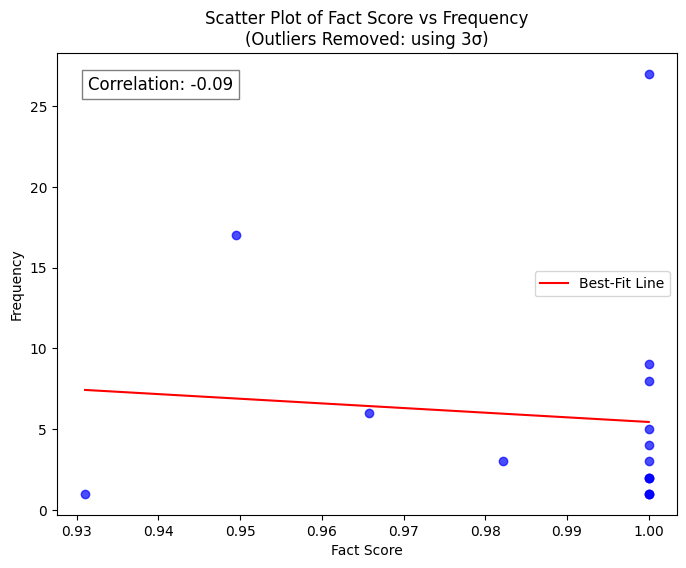

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Get the common facts between the two dictionaries
common_facts = {fact for fact in fact_final_scores if fact in fact_frequency and fact_frequency[fact] != 0}

# Create lists for scores and frequencies
scores = [fact_final_scores[fact] for fact in common_facts]
frequencies = [fact_frequency[fact] for fact in common_facts]

freq_array = np.array(frequencies)
score_array = np.array(scores)
mean_score = np.mean(score_array)
std_score = np.std(score_array)
mean_freq = np.mean(freq_array)
std_freq = np.std(freq_array)

lower_bound_score_std = mean_score - 3 * std_score
upper_bound_score_std = mean_score + 3 * std_score
lower_bound_freq_std = mean_freq - 3 * std_freq
upper_bound_freq_std = mean_freq + 3 * std_freq

print("3σ Score Lower bound:", lower_bound_score_std, "Upper bound:", upper_bound_score_std)
print("3σ Frequency Lower bound:", lower_bound_freq_std, "Upper bound:", upper_bound_freq_std)

# ---- Combine Both Filters ----
filtered_scores = []
filtered_frequencies = []
for score, freq in zip(scores, frequencies):
    if (
        lower_bound_score_std <= score <= upper_bound_score_std and 
        lower_bound_freq_std <= freq<= 170):#upper_bound_freq_std):
        filtered_scores.append(score)
        filtered_frequencies.append(freq)
print(len(filtered_scores))
# ---- Plot the Filtered Data ----
plt.figure(figsize=(8, 6))
plt.scatter(filtered_scores, filtered_frequencies, color='blue', alpha=0.7)
plt.xlabel('Fact Score')
plt.ylabel('Frequency')
plt.title('Scatter Plot of Fact Score vs Frequency\n(Outliers Removed: using 3σ)')

# Fit a best-fit line if there are enough data points
if len(filtered_scores) > 1:
    m, b = np.polyfit(filtered_scores, filtered_frequencies, 1)
    x_vals = np.linspace(min(filtered_scores), max(filtered_scores), 100)
    y_vals = m * x_vals + b
    plt.plot(x_vals, y_vals, color='red', label='Best-Fit Line')
    plt.legend()
    
    # Compute the Pearson correlation coefficient on the filtered data
    corr_coef = np.corrcoef(filtered_scores, filtered_frequencies)[0, 1]
    plt.text(0.05, 0.95, f'Correlation: {corr_coef:.2f}', transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
else:
    plt.text(0.05, 0.95, 'Not enough data to compute correlation', transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

plt.show()


In [11]:
import numpy as np
from scipy.stats import pearsonr

def permutation_test_corr(x, y, num_permutations=10000):
    observed_corr, _ = pearsonr(x, y)
    count = 0
    for _ in range(num_permutations):
        # Randomly shuffle y to break any association with x
        permuted_y = np.random.permutation(y)
        permuted_corr, _ = pearsonr(x, permuted_y)
        if abs(permuted_corr) >= abs(observed_corr):
            count += 1
    p_value = count / num_permutations
    return observed_corr, p_value


observed_corr, p_val = permutation_test_corr(filtered_scores, filtered_frequencies)
print("Observed Pearson correlation:", observed_corr)
print("Permutation test p-value:", p_val)


Observed Pearson correlation: nan
Permutation test p-value: 0.0


/var/folders/v0/scpypmc57k7f574snt7ck__h0000gn/T/ipykernel_28699/866701025.py:5: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  observed_corr, _ = pearsonr(x, y)
/var/folders/v0/scpypmc57k7f574snt7ck__h0000gn/T/ipykernel_28699/866701025.py:10: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  permuted_corr, _ = pearsonr(x, permuted_y)


In [12]:
from scipy.stats import kendalltau

# Compute Kendall's tau correlation coefficient and p-value
kendall_corr, kendall_p = kendalltau(filtered_scores, filtered_frequencies)
print("Kendall's tau correlation coefficient:", kendall_corr)
print("p-value:", kendall_p)


Kendall's tau correlation coefficient: nan
p-value: nan


In [13]:
# from evaluate import load
# perplexity = load("perplexity", module_type="metric")
# input_texts = ["lorem ipsum", "Happy Birthday!", "Bienvenue"]
# results = perplexity.compute(model_id='allenai/OLMo-2-1124-13B-Instruct',
#                              add_start_token=False,
#                              predictions=input_texts)

# maybe try: meta-llama/Llama-3.1-405B-Instruct & olmo 2

In [14]:
# results